# Performance Evaluation

In [1]:
# wir benötigen wieder ein paar python imports...
%matplotlib inline
import sys
from os import environ
import os
import time
import uuid
import asyncio
import random
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))

from sparql_queries import *
from connector_client import ConnectorClient
from connector.messages.datamodel_utils import SubscriptionRegisterRequest, SubscriptionUnregisterRequest # generic messages within the connector_base repo

client = ConnectorClient(bootstrap_servers=[environ.get("KAFKA_BROKER")])

# graphdb queries, um den richtigen connector zu identifizieren
await client.load_connector_config()
await client.return_connectors()

dict_keys(['milling_station', 'injection_molding', 'assembly_station'])

In [2]:
# wechsel an den ausgewählten, richtigen connector
await client.switch_connector('milling_station')

In [3]:
# necessary subscriptions for later query_performance_test

async def create_subscription():
    # definieren einer Subscribe-Nachricht für einen OPC-UA-Server, welche bereits als pydantic model oder als json schema gegeben ist
    subscription_id = uuid.uuid4()
    print(f"Subscription Identifier: {subscription_id}")
    example_subscribe_payload = SubscriptionRegisterRequest(
        datapoint_identifier=["ns=2;i=62"],
        device_origin="client",
        subscription_identifier=subscription_id
    )
    start_time = time.time()
    out = await client.subscribe_data_source(example_subscribe_payload);
    end_time = time.time()
    subscription_request_response_time = end_time - start_time
    return subscription_id, subscription_request_response_time

async def query_performance(subscription_id):
    start_time = time.time()
    while True:
        try:
            out = await client.query_graphdb(build_subscription_by_id_query(str(subscription_id)), pretty=False)
    
            if out and len(out)>0:
                break
    
        except Exception:
            pass
    
    end_time = time.time()
    query_performance_time = end_time - start_time
    return query_performance_time

async def subscription_query_graphdb_performance():
    start_time = time.time()
    subscription_id, subscription_request_response_time = await create_subscription();

    query_performance_time = await query_performance(subscription_id)
    
    end_time = time.time()
    time.sleep(0.1)
    subscription_query_graphdb_performance = end_time - start_time
    return subscription_request_response_time, query_performance_time, subscription_query_graphdb_performance

## Query performance test


In [4]:
# first do 100 subscriptions and register them
subscription_id_list = []
for idx in range(100):
    subscription_id, subscription_request_response_time = await create_subscription();
    subscription_id_list.append(subscription_id)

Subscription Identifier: c0aa07ee-dd2d-49f9-bb21-1d7802ea0c1f
Correlation_id of sent message: fefe7bb4-08e5-4e10-b852-84d30661346c
waiting for a message
Received message
{'correlation_id': 'fefe7bb4-08e5-4e10-b852-84d30661346c',
 'message_id': 'c8716584-ed60-416f-83f9-8ecc34f5f634',
 'payload': {'base_payload': {'device_origin': 'connector_opcua',
                              'response': 'Worked',
                              'type': 'SubscriptionRegisterResponse'},
             'type': 'CommandResponse'},
 'service_id': 'milling_station',
 'status_code': 'Valid',
 'timestamp': '2025-04-30T13:28:45.299776',
 'type': 'ResponseMessage',
 'version': '1.0.0'}
message type: <class 'connector.messages.datamodel_utils.SubscriptionRegisterResponse'>
Matching response received:
{
    "type": "SubscriptionRegisterResponse",
    "device_origin": "connector_opcua",
    "response": "Worked"
}
Subscription Identifier: 49b91b45-d499-4817-adae-33e96e6a886c
Correlation_id of sent message: fc135d33-ca

In [5]:
# then measure the time needed for a graphdb request finding them
query_performance_results = []
for idx in range(100):
    random_subscription_id = random.choice(subscription_id_list)
    print(f"Test Nr. {idx} with subscription identifier: {random_subscription_id}")
    result = await query_performance(subscription_id)
    query_performance_results.append(result)

Test Nr. 0 with subscription identifier: 27932e18-4cfa-40dc-885d-e8480314317a
Test Nr. 1 with subscription identifier: b02e60ad-b186-4e11-b9b5-3ef58b884b66
Test Nr. 2 with subscription identifier: 3e81e3d7-4de3-4f7f-9e9b-7bf50a74bde7
Test Nr. 3 with subscription identifier: 4a0f8fdf-7ddf-4568-9b12-6cdf7c3412e4
Test Nr. 4 with subscription identifier: c13d8564-ea47-471b-9377-401799b9d68c
Test Nr. 5 with subscription identifier: 5ff563b9-08a5-4cf4-a279-e0b675a8d738
Test Nr. 6 with subscription identifier: 23a08674-9c49-4866-b76f-acf9fb118782
Test Nr. 7 with subscription identifier: 04fabc2d-d4e1-4a50-b627-ee0894eb48bb
Test Nr. 8 with subscription identifier: 0526d5ae-954f-45eb-aeae-9d3101210314
Test Nr. 9 with subscription identifier: f3dd863d-ac2b-4201-b9dc-f0f4d675a10a
Test Nr. 10 with subscription identifier: 23721e39-7e7a-420b-b261-16e33fa7b926
Test Nr. 11 with subscription identifier: 49b91b45-d499-4817-adae-33e96e6a886c
Test Nr. 12 with subscription identifier: d6cdcef6-d88e-4a92-9

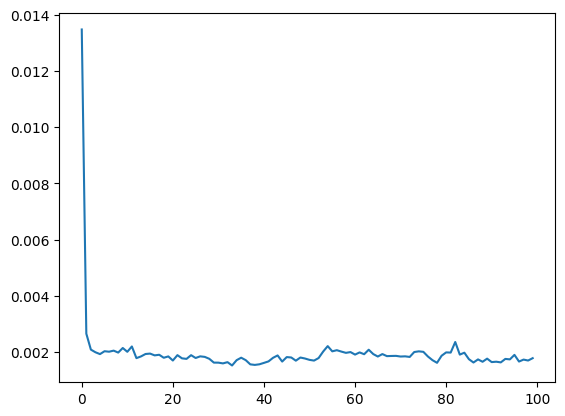

In [6]:
plt.plot(query_performance_results)

## Subscription Performance Test

In [7]:
# measure the "loop" between subscription request and graphdb occurance of the 
subscription_performance_query_results = []
for idx in range(100):
    #random_subscription_id = random.choice(subscription_id_list)
    #print(f"Test Nr. {idx} with subscription identifier: {random_subscription_id}")
    result = await subscription_query_graphdb_performance()
    subscription_performance_query_results.append(result)

Subscription Identifier: 11a541a3-1f04-4fc4-9242-114bc7ca06e2
Correlation_id of sent message: 0ee84907-1154-4c7e-bcaa-338722be18c4
waiting for a message
Received message
{'correlation_id': '0ee84907-1154-4c7e-bcaa-338722be18c4',
 'message_id': '076a242d-c032-47fe-a066-93e904fa13d6',
 'payload': {'base_payload': {'device_origin': 'connector_opcua',
                              'response': 'Worked',
                              'type': 'SubscriptionRegisterResponse'},
             'type': 'CommandResponse'},
 'service_id': 'milling_station',
 'status_code': 'Valid',
 'timestamp': '2025-04-30T13:29:06.132077',
 'type': 'ResponseMessage',
 'version': '1.0.0'}
message type: <class 'connector.messages.datamodel_utils.SubscriptionRegisterResponse'>
Matching response received:
{
    "type": "SubscriptionRegisterResponse",
    "device_origin": "connector_opcua",
    "response": "Worked"
}
Subscription Identifier: 1f40f033-4374-4ec7-b1c6-b0f56fa900d5
Correlation_id of sent message: 281c0056-73

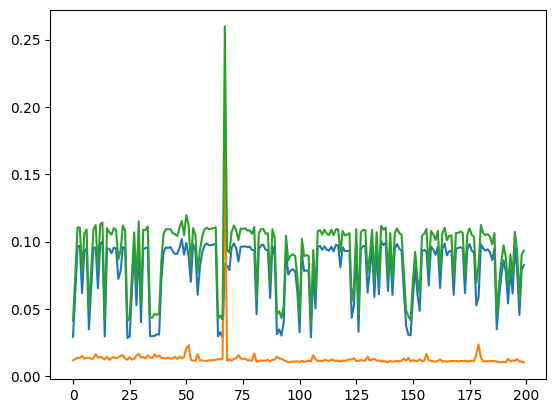

In [8]:
plt.plot(subscription_performance_query_results)
#plt.plot(query_performance_results)

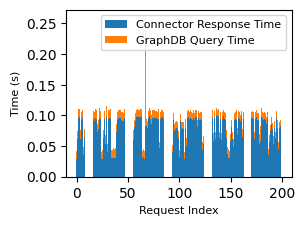

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os

data = subscription_performance_query_results

# Unpack the data
subscription_times = [row[0] for row in data]
query_times = [row[1] for row in data]
total_times = [row[2] for row in data]  # optional for reference

# X-axis positions
x = np.arange(len(data))

# Plot
plt.figure(figsize=(8 /2.54, 6/2.54))
plt.bar(x, subscription_times, label='Connector Response Time')
plt.bar(x, query_times, bottom=subscription_times, label='GraphDB Query Time')

plt.xlabel('Request Index', fontsize=8)
plt.ylabel('Time (s)', fontsize=8)
plt.legend(fontsize=8)
plt.tight_layout()

# Save to figures/ folder
os.makedirs("figures", exist_ok=True)
plt.tight_layout()
plt.savefig("figures/subscription_query_stacked.pdf", dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()


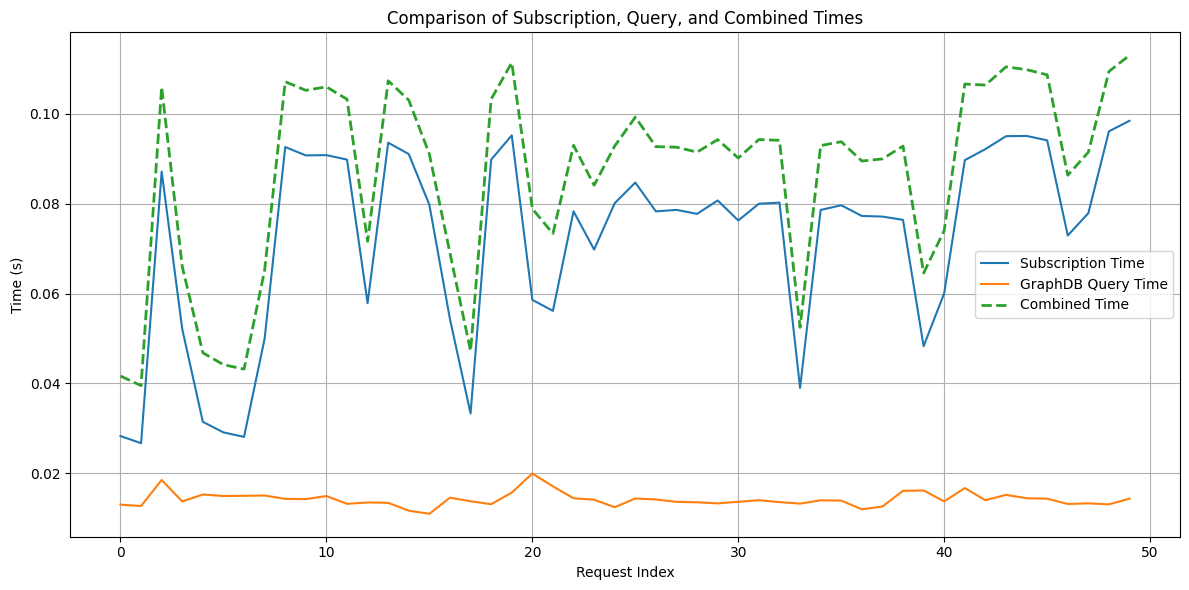

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(subscription_times, label="Subscription Time", linewidth=1.5)
plt.plot(query_times, label="GraphDB Query Time", linewidth=1.5)
plt.plot(total_times, label="Combined Time", linewidth=2, linestyle='--')

plt.xlabel('Request Index')
plt.ylabel('Time (s)')
plt.title('Comparison of Subscription, Query, and Combined Times')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Request Response performance test

Testing the number of

In [9]:
request_response_performance_results = []
for idx in range(100):
    print(f"Test Nr. {idx} with subscription identifier:")
    start_time = time.time()
    result = await create_subscription()
    end_time = time.time()
    result = end_time - start_time
    request_response_performance_results.append(result)

Test Nr. 0 with subscription identifier:
Subscription Identifier: fb8b1d8e-9c95-4826-bea7-d8d243fa8822
Correlation_id of sent message: f5973db0-64cb-4a25-b5d2-54c15d6f1128
waiting for a message
Received message
{'correlation_id': 'f5973db0-64cb-4a25-b5d2-54c15d6f1128',
 'message_id': '1dca4691-67a9-486c-8a9d-936c8bceba40',
 'payload': {'base_payload': {'device_origin': 'connector_opcua',
                              'response': 'Worked',
                              'type': 'SubscriptionRegisterResponse'},
             'type': 'CommandResponse'},
 'service_id': 'milling_station',
 'status_code': 'Valid',
 'timestamp': '2025-04-29T16:46:21.949281',
 'type': 'ResponseMessage',
 'version': '1.0.0'}
message type: <class 'connector.messages.datamodel_utils.SubscriptionRegisterResponse'>
Matching response received:
{
    "type": "SubscriptionRegisterResponse",
    "device_origin": "connector_opcua",
    "response": "Worked"
}
Test Nr. 1 with subscription identifier:
Subscription Identifier

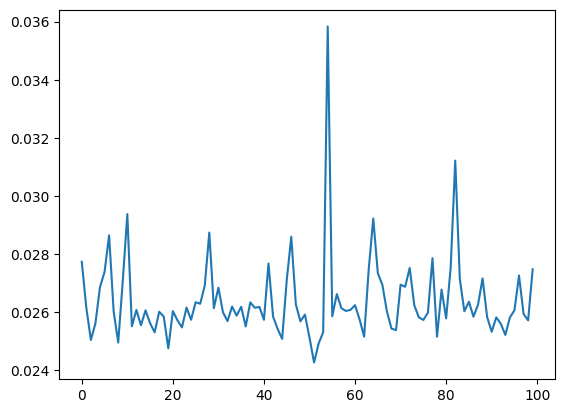

In [10]:
plt.plot(request_response_performance_results)

### plot all togehter

In [13]:
plt.plot(subscription_performance_query_results labels = ["query performance", "query_performance"])
plt.plot(request_response_performance_results)
plt.plot(query_performance_results)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1027979.py, line 1)

## Client Scalability Performance test

Testing the performance of the fabric using one connector and topic together with a rising number of clients to check client accessibility

In [29]:
import asyncio
import time
import uuid
from os import environ

# You define this according to your models/system
# from your_module import ConnectorClient, SubscriptionRegisterRequest, build_subscription_by_id_query


async def create_subscription(client):
    subscription_id = uuid.uuid4()
    example_subscribe_payload = SubscriptionRegisterRequest(
        datapoint_identifier=["ns=2;i=62"],
        device_origin="client",
        subscription_identifier=subscription_id
    )
    await client.subscribe_data_source(example_subscribe_payload);
    return subscription_id


async def subscription_performance():
    client = ConnectorClient(bootstrap_servers=[environ.get("KAFKA_BROKER")])
    await client.load_connector_config()
    await client.return_connectors()
    await client.switch_connector('milling_station')

    start_time = time.time()

    subscription_id = await create_subscription(client);

    while True:
        try:
            out = await client.query_graphdb(build_subscription_by_id_query(str(subscription_id)), pretty=False);
            if out and len(out) > 0:
                break
        except Exception:
            pass
        await asyncio.sleep(0.1)  # prevent busy-loop

    end_time = time.time()
    await client.close()
    return end_time - start_time


async def run_scaling_test(max_clients: int = 10):
    results = []

    for n_clients in range(1, max_clients + 1):
        print(f"\n🔄 Running test with {n_clients} parallel clients...")

        tasks = [subscription_performance() for _ in range(n_clients)]

        start_time = time.time()
        durations = await asyncio.gather(*tasks);
        end_time = time.time()

        avg_duration = sum(durations) / len(durations)
        print(f"✅ {n_clients} clients finished. Avg duration: {avg_duration:.2f} s (Total: {end_time - start_time:.2f} s)")

        results.append((n_clients, avg_duration))

    return results


In [32]:
results = await run_scaling_test(max_clients=30)


🔄 Running test with 1 parallel clients...
Correlation_id of sent message: afed9034-4d8b-4f73-a027-41d9d7f6a70a
waiting for a message
Received message
{'correlation_id': 'afed9034-4d8b-4f73-a027-41d9d7f6a70a',
 'message_id': '5f838b45-cf2a-4dde-bf14-8275b35a4d27',
 'payload': {'base_payload': {'device_origin': 'connector_opcua',
                              'response': 'Worked',
                              'type': 'SubscriptionRegisterResponse'},
             'type': 'CommandResponse'},
 'service_id': 'milling_station',
 'status_code': 'Valid',
 'timestamp': '2025-04-30T15:38:35.812829',
 'type': 'ResponseMessage',
 'version': '1.0.0'}
message type: <class 'connector.messages.datamodel_utils.SubscriptionRegisterResponse'>
Matching response received:
{
    "type": "SubscriptionRegisterResponse",
    "device_origin": "connector_opcua",
    "response": "Worked"
}
✅ 1 clients finished. Avg duration: 0.13 s (Total: 0.13 s)

🔄 Running test with 2 parallel clients...
Correlation_id of sent

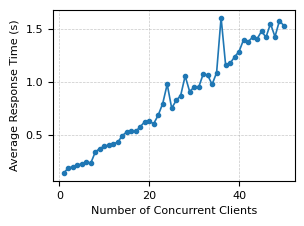

In [27]:

# Assuming you have this:
# results = [(1, 0.5), (2, 0.8), (3, 1.2), ...]
num_clients, avg_durations = zip(*results)

# Convert to numpy arrays for safety
num_clients = np.array(num_clients)
avg_durations = np.array(avg_durations)

# Plot
plt.figure(figsize=(8 / 2.54, 6 / 2.54))  # ~A6 size in cm
plt.plot(num_clients, avg_durations, marker='o', linewidth=1.2, markersize=3)

plt.xlabel('Number of Concurrent Clients', fontsize=8)
plt.ylabel('Average Response Time (s)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save to figures/ folder
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/avg_duration_vs_clients.pdf", dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()